# Indentification of spatial domains with GraphST

We used the sample 151673 from DLPFC dataset to find optimal parameters (this dataset comtain ground truth).

Then we used GraphST with the parameters previously found to identify spatial domain in PDAC dataset. 

As we don't have ground truth on these data, we can't conclude on the region obtained.

# 0. Preliminary steps

## 0.1. Install GraphST

#create an environment called GraphST

conda create -n GraphST python=3.8

#activate your environment

conda activate GraphST

#install package

pip install GraphST

#To use the environment in jupyter notebook, add python kernel for this environment.

pip install ipykernel

python -m ipykernel install --user --name=GraphST

pip install torch

pip install pandas

pip install scanpy

pip install igraph

pip install louvain

pip install leidenalg

pip install POT

pip install --user scikit-misc

Change the kernel in : Kernel -> Change Kernel -> GraphST

## 0.2. Load packages

In [1]:
import os
import scanpy as sc
import torch
import pandas as pd
from sklearn import metrics
import multiprocessing as mp
from GraphST import GraphST
# For clustering
from GraphST.utils import clustering
import louvain
import leidenalg
# import ARI score
from sklearn.metrics.cluster import adjusted_rand_score
from matplotlib import pyplot as plt
from sklearn import metrics

In [34]:
# Run device, by default, the package is implemented on 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Function definition

In [3]:
def perform_graph_st(adata, device, n_clusters, name):
    """Perform GraphST on visium data.

    Parameters
    ----------
    path : string
        Path of visium data.
    n_clusters : int
        Number of clusters
    device

    Returns
    -------
    adata
        AnnData object with spatial domains in adata.obs['domain']
    """
    adata.var_names_make_unique()
    # define model
    model = GraphST.GraphST(adata, device=device)
    # train model
    adata = model.train()
    # set radius to specify the number of neighbors considered during refinement
    radius = 50
    tool = "leiden"
    clustering(adata, n_clusters, radius=radius, method=tool, start=0.1, end=2.0, increment=0.01, refinement=True)
    # save in output files
    sevenbg_output_path = f"/sbgenomics/output-files/graphst_anndata"
    os.makedirs(sevenbg_output_path, exist_ok=True)
    adata.write(f"{sevenbg_output_path}/{name}.h5ad")
    
    # plotting spatial clustering result
    sc.pl.spatial(adata, color = tool, show = True)
    # plotting predicted labels by UMAP
    sc.pp.neighbors(adata, use_rep='emb_pca', n_neighbors=10)
    sc.tl.umap(adata)
    sc.pl.umap(adata, color='domain', title=['Predicted labels'], show=False)
    return(adata)

Tool could be louvain, leiden or mclust. For mclust, R path is needed. By default, we used Louvain algorithm

The refinement step is not recommended for ST data with fine-grained domains, Stereo-seq and Slide-seqV2.
For a given spot, its lable will be re-assigned as the same domain as the most common lable of its surronding spots.

# 1. GraphST with DLPFC dataset : Find optimal parameters

We used sample 151673 from DLPFC dataset to find optimal parameters for clustering. However, these parameters are optimal only for DLPFC dataset. As we don't have any ground truth for PDAC dataset, we keep these parameters for our analysis.

To find optimal parameters, we compared : 
1. clustering results with and without refinement
2. clustering results before and after preprocessing
3. clustering results between Louvain and Leiden algorithms

In [12]:
n_clusters = 7 # number of layers in ground truth

In [11]:
# add ground_truth
file_fold = "../151673"
df_meta = pd.read_csv(file_fold + '/metadata.tsv', sep='\t')
df_meta_layer = df_meta['layer_guess']

## 1.1. Comparison of clustering results with and without refinement on raw data

With Leiden algorithm

### Without refinement :

In [6]:
adata = sc.read_visium("../151673/") 

/opt/conda/envs/GraphST/lib/python3.8/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [7]:
adata.var_names_make_unique()

In [8]:
# define model
model = GraphST.GraphST(adata, device=device)

# train model
adata = model.train()

Begin to train ST data...


100%|██████████| 600/600 [01:26<00:00,  6.94it/s]

Optimization finished for ST data!


In [15]:
clustering(adata, n_clusters, radius=50, method="leiden", start=0.1, end=2.0, increment=0.01, refinement=False)

Searching resolution...


/opt/conda/envs/GraphST/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/envs/GraphST/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/envs/GraphST/lib/python3.8/site-packages/umap/distances.py:1086: NumbaDeprecationWa

resolution=1.989999999999999, cluster number=18
resolution=1.979999999999999, cluster number=18
resolution=1.969999999999999, cluster number=17
resolution=1.959999999999999, cluster number=16
resolution=1.949999999999999, cluster number=18
resolution=1.939999999999999, cluster number=18
resolution=1.9299999999999993, cluster number=16
resolution=1.9199999999999993, cluster number=16
resolution=1.9099999999999993, cluster number=16
resolution=1.8999999999999992, cluster number=16
resolution=1.8899999999999992, cluster number=16
resolution=1.8799999999999992, cluster number=16
resolution=1.8699999999999992, cluster number=16
resolution=1.8599999999999992, cluster number=16
resolution=1.8499999999999992, cluster number=16
resolution=1.8399999999999992, cluster number=16
resolution=1.8299999999999992, cluster number=16
resolution=1.8199999999999992, cluster number=16
resolution=1.8099999999999992, cluster number=16
resolution=1.7999999999999992, cluster number=16
resolution=1.7899999999999

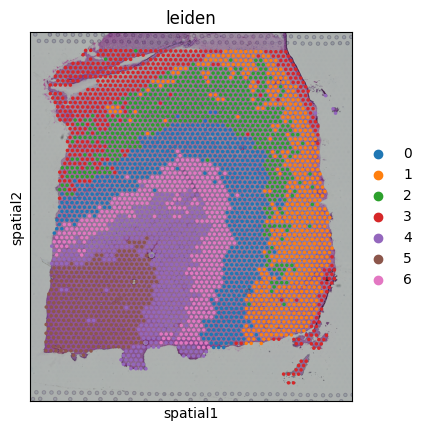

/opt/conda/envs/GraphST/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'Predicted labels'}, xlabel='UMAP1', ylabel='UMAP2'>

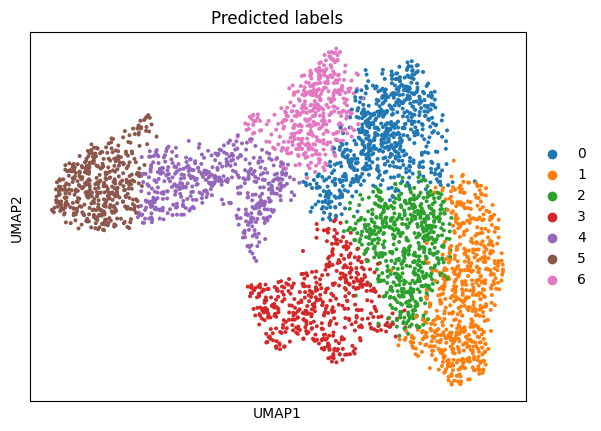

In [16]:
# plotting spatial clustering result
sc.pl.spatial(adata, color = 'leiden', show = True)
# plotting predicted labels by UMAP
sc.pp.neighbors(adata, use_rep='emb_pca', n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(adata, color='domain', title=['Predicted labels'], show=False)

In [17]:
adata.obs['ground_truth'] = df_meta_layer.values

In [18]:
# filter out NA nodes
adata = adata[~pd.isnull(adata.obs['ground_truth'])]

# calculate metric ARI
ARI = metrics.adjusted_rand_score(adata.obs['domain'], adata.obs['ground_truth'])
adata.uns['ARI'] = ARI

print('ARI:', ARI)

/tmp/ipykernel_990/4192629481.py:6: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['ARI'] = ARI


ARI: 0.5006041752378678


### With refinement :

In [19]:
adata2 = sc.read_visium("../151673/") 

/opt/conda/envs/GraphST/lib/python3.8/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [20]:
adata2.var_names_make_unique()

In [21]:
# define model
model = GraphST.GraphST(adata2, device=device)

# train model
adata2 = model.train()

Begin to train ST data...


100%|██████████| 600/600 [11:50<00:00,  1.18s/it]


Optimization finished for ST data!


In [22]:
clustering(adata2, n_clusters, radius=50, method="leiden", start=0.1, end=2.0, increment=0.01, refinement=True)

Searching resolution...
resolution=1.989999999999999, cluster number=18
resolution=1.979999999999999, cluster number=18
resolution=1.969999999999999, cluster number=17
resolution=1.959999999999999, cluster number=16
resolution=1.949999999999999, cluster number=18
resolution=1.939999999999999, cluster number=18
resolution=1.9299999999999993, cluster number=16
resolution=1.9199999999999993, cluster number=16
resolution=1.9099999999999993, cluster number=16
resolution=1.8999999999999992, cluster number=16
resolution=1.8899999999999992, cluster number=16
resolution=1.8799999999999992, cluster number=16
resolution=1.8699999999999992, cluster number=16
resolution=1.8599999999999992, cluster number=16
resolution=1.8499999999999992, cluster number=16
resolution=1.8399999999999992, cluster number=16
resolution=1.8299999999999992, cluster number=16
resolution=1.8199999999999992, cluster number=16
resolution=1.8099999999999992, cluster number=16
resolution=1.7999999999999992, cluster number=16
re

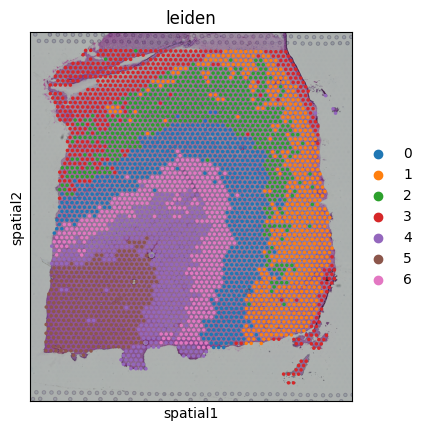

In [ ]:
# plotting spatial clustering result
sc.pl.spatial(adata2, color = "leiden", show = True)
# plotting predicted labels by UMAP
sc.pp.neighbors(adata2, use_rep='emb_pca', n_neighbors=10)
sc.tl.umap(adata2)
sc.pl.umap(adata2, color='domain', title=['Predicted labels'], show=False)

In [ ]:
adata2.obs['ground_truth'] = df_meta_layer.values

In [49]:
# filter out NA nodes
adata2 = adata2[~pd.isnull(adata2.obs['ground_truth'])]

# calculate metric ARI
ARI = metrics.adjusted_rand_score(adata2.obs['domain'], adata2.obs['ground_truth'])
adata2.uns['ARI'] = ARI

print('ARI:', ARI)

/tmp/ipykernel_990/2740974671.py:6: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata2.uns['ARI'] = ARI


ARI: 0.5121256929838238


In [50]:
adata2

AnnData object with n_obs × n_vars = 3611 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'leiden', 'domain', 'ground_truth'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg', 'log1p', 'neighbors', 'leiden', 'leiden_colors', 'umap', 'domain_colors', 'ARI'
    obsm: 'spatial', 'distance_matrix', 'graph_neigh', 'adj', 'label_CSL', 'feat', 'feat_a', 'emb', 'emb_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

In [52]:
# save in output files
sevenbg_output_path = f"/sbgenomics/output-files/graphst_anndata"
os.makedirs(sevenbg_output_path, exist_ok=True)
adata2.write(f"{sevenbg_output_path}/151573_graphst_anndata.h5ad")

## 1.2. Comparison between raw and preprocessed data

With Leiden algorithm and refinement = False

### Raw data

As we have run refinement test on raw data, we use the condition with the best ARI score for this part.
The best result is without refinement, so we keep 0.5121 as ARI score.

### Preprocessed data

In [31]:
tool = 'leiden'

In [30]:
radius = 50

In [29]:
path_151673_preprocessed = "/../../sbgenomics/project-files/visium_preprocessed/dplfc_151673_preprocessed.h5ad" 

In [34]:
visium_157673_preprocessed = sc.read_h5ad(path_151673_preprocessed)
visium_157673_preprocessed.var_names_make_unique()

In [35]:
# define model
model = GraphST.GraphST(visium_157673_preprocessed, device=device)

# train model
visium_157673_preprocessed = model.train()

Begin to train ST data...


100%|██████████| 600/600 [10:37<00:00,  1.06s/it]


Optimization finished for ST data!


In [36]:
clustering(visium_157673_preprocessed, n_clusters, radius=50, method='leiden', start=0.1, end=2.0, increment=0.01, refinement=True)

Searching resolution...
resolution=1.989999999999999, cluster number=18
resolution=1.979999999999999, cluster number=18
resolution=1.969999999999999, cluster number=17
resolution=1.959999999999999, cluster number=18
resolution=1.949999999999999, cluster number=18
resolution=1.939999999999999, cluster number=16
resolution=1.9299999999999993, cluster number=18
resolution=1.9199999999999993, cluster number=16
resolution=1.9099999999999993, cluster number=18
resolution=1.8999999999999992, cluster number=18
resolution=1.8899999999999992, cluster number=16
resolution=1.8799999999999992, cluster number=17
resolution=1.8699999999999992, cluster number=16
resolution=1.8599999999999992, cluster number=15
resolution=1.8499999999999992, cluster number=16
resolution=1.8399999999999992, cluster number=16
resolution=1.8299999999999992, cluster number=15
resolution=1.8199999999999992, cluster number=15
resolution=1.8099999999999992, cluster number=15
resolution=1.7999999999999992, cluster number=15
re

In [37]:
visium_157673_preprocessed

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'clusters', 'leiden', 'domain'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_colors', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'distance_matrix', 'graph_neigh', 'adj', 'label_CSL', 'feat', 'feat_a', 'emb', 'emb_pca'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

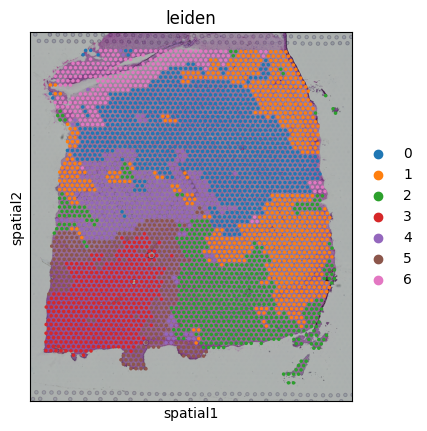

/opt/conda/envs/GraphST/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'Predicted labels'}, xlabel='UMAP1', ylabel='UMAP2'>

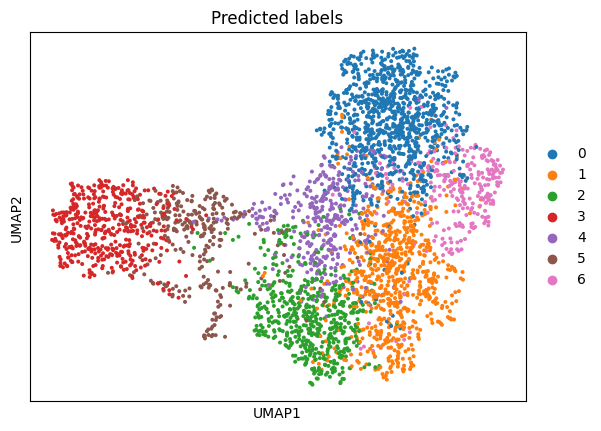

In [38]:
# plotting spatial clustering result
sc.pl.spatial(visium_157673_preprocessed, color = 'leiden', show = True)
# plotting predicted labels by UMAP
sc.pp.neighbors(visium_157673_preprocessed, use_rep='emb_pca', n_neighbors=10)
sc.tl.umap(visium_157673_preprocessed)
sc.pl.umap(visium_157673_preprocessed, color='domain', title=['Predicted labels'], show=False)

In [39]:
visium_157673_preprocessed.obs['ground_truth'] = df_meta_layer.values

In [40]:
# filter out NA nodes
visium_157673_preprocessed = visium_157673_preprocessed[~pd.isnull(visium_157673_preprocessed.obs['ground_truth'])]

# calculate metric ARI
ARI = metrics.adjusted_rand_score(visium_157673_preprocessed.obs['domain'], visium_157673_preprocessed.obs['ground_truth'])
visium_157673_preprocessed.uns['ARI'] = ARI

print('ARI:', ARI) 

/tmp/ipykernel_990/1303486577.py:6: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  visium_157673_preprocessed.uns['ARI'] = ARI


ARI: 0.28868957064693856


## 1.3. Comparison between Leiden and Louvain algorithm

### Leiden algorithm

Like before, we already have the results for clustering with Leiden algorithm. We used the best result of the condition with refinement and with raw data. The ARI score is 0.5121

### Louvain algorithm

In [41]:
adata_louvain = sc.read_visium("../151673/") 

/opt/conda/envs/GraphST/lib/python3.8/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [42]:
adata_louvain.var_names_make_unique()

In [43]:
# define model
model = GraphST.GraphST(adata_louvain, device=device)

# train model
adata_louvain = model.train()

Begin to train ST data...


100%|██████████| 600/600 [11:35<00:00,  1.16s/it]


Optimization finished for ST data!


In [44]:
tool = "louvain"

In [45]:
clustering(adata_louvain, n_clusters, radius=radius, method=tool, start=0.1, end=2.0, increment=0.01, refinement=True)

Searching resolution...
resolution=1.989999999999999, cluster number=12
resolution=1.979999999999999, cluster number=12
resolution=1.969999999999999, cluster number=12
resolution=1.959999999999999, cluster number=12
resolution=1.949999999999999, cluster number=12
resolution=1.939999999999999, cluster number=12
resolution=1.9299999999999993, cluster number=12
resolution=1.9199999999999993, cluster number=12
resolution=1.9099999999999993, cluster number=12
resolution=1.8999999999999992, cluster number=12
resolution=1.8899999999999992, cluster number=12
resolution=1.8799999999999992, cluster number=12
resolution=1.8699999999999992, cluster number=12
resolution=1.8599999999999992, cluster number=12
resolution=1.8499999999999992, cluster number=12
resolution=1.8399999999999992, cluster number=12
resolution=1.8299999999999992, cluster number=12
resolution=1.8199999999999992, cluster number=12
resolution=1.8099999999999992, cluster number=12
resolution=1.7999999999999992, cluster number=12
re

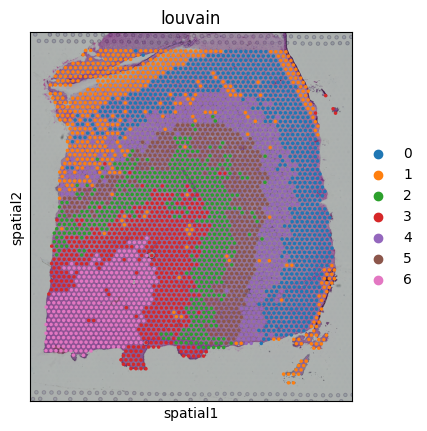

/opt/conda/envs/GraphST/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'Predicted labels'}, xlabel='UMAP1', ylabel='UMAP2'>

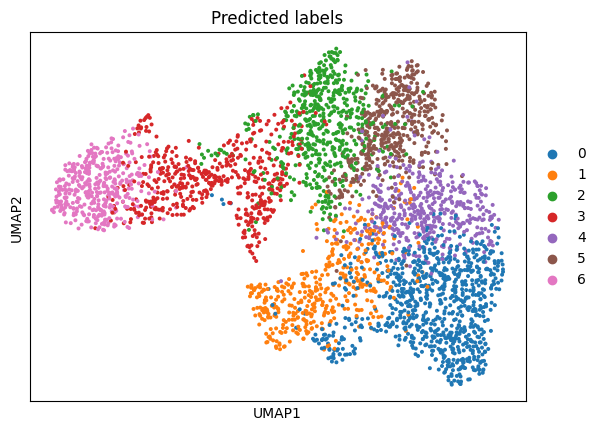

In [46]:
# plotting spatial clustering result
sc.pl.spatial(adata_louvain, color = "louvain", show = True)
# plotting predicted labels by UMAP
sc.pp.neighbors(adata_louvain, use_rep='emb_pca', n_neighbors=10)
sc.tl.umap(adata_louvain)
sc.pl.umap(adata_louvain, color='domain', title=['Predicted labels'], show=False)

In [47]:
adata_louvain.obs['ground_truth'] = df_meta_layer.values

In [48]:
# filter out NA nodes
adata_louvain = adata_louvain[~pd.isnull(adata_louvain.obs['ground_truth'])]

# calculate metric ARI
ARI = metrics.adjusted_rand_score(adata_louvain.obs['domain'], adata_louvain.obs['ground_truth'])
adata_louvain.uns['ARI'] = ARI

print('ARI:', ARI)

/tmp/ipykernel_990/3286338736.py:6: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata_louvain.uns['ARI'] = ARI


ARI: 0.46779079315837013


# 2. Perform GraphST on PDAC dataset

We performed GraphST on PDAC dataset with the best parameters for 151673 slices.
These parameters are : 
- raw data
- with refinement
- Leiden algorithm

We tested two number of clusters for each sample : 10 and 6

## 2.1. With number of cluster = 10

In [9]:
n_clusters = 10

### A1 :

In [10]:
A1_visium = sc.read_h5ad("/../../sbgenomics/project-files/st_pancreas_h5ad/PDAC_A1_visium.h5ad")

/opt/conda/envs/GraphST/lib/python3.8/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [11]:
name_A1_10clust = "PDAC_A1_anndata_graphst_10_clusters"

Begin to train ST data...


100%|██████████| 600/600 [00:30<00:00, 19.75it/s]


Optimization finished for ST data!
Searching resolution...


/opt/conda/envs/GraphST/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/envs/GraphST/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/envs/GraphST/lib/python3.8/site-packages/umap/distances.py:1086: NumbaDeprecationWa

resolution=1.989999999999999, cluster number=21
resolution=1.979999999999999, cluster number=21
resolution=1.969999999999999, cluster number=21
resolution=1.959999999999999, cluster number=21
resolution=1.949999999999999, cluster number=21
resolution=1.939999999999999, cluster number=21
resolution=1.9299999999999993, cluster number=21
resolution=1.9199999999999993, cluster number=20
resolution=1.9099999999999993, cluster number=20
resolution=1.8999999999999992, cluster number=19
resolution=1.8899999999999992, cluster number=20
resolution=1.8799999999999992, cluster number=19
resolution=1.8699999999999992, cluster number=19
resolution=1.8599999999999992, cluster number=20
resolution=1.8499999999999992, cluster number=19
resolution=1.8399999999999992, cluster number=20
resolution=1.8299999999999992, cluster number=20
resolution=1.8199999999999992, cluster number=20
resolution=1.8099999999999992, cluster number=20
resolution=1.7999999999999992, cluster number=20
resolution=1.7899999999999

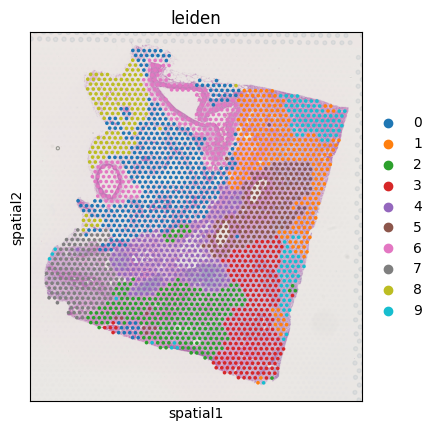

/opt/conda/envs/GraphST/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


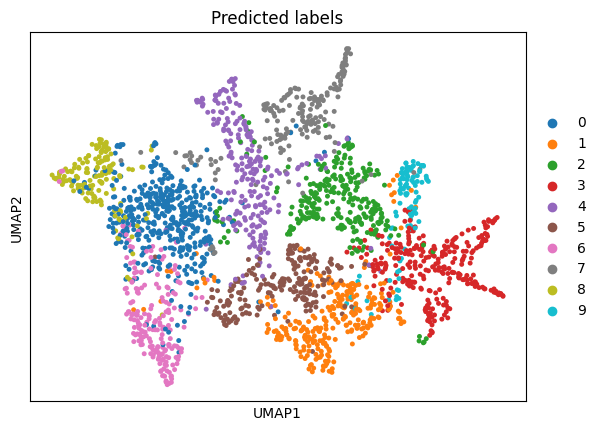

In [12]:
A1_visium = perform_graph_st(A1_visium, device, n_clusters, name_A1_10clust)

### B2 :

In [13]:
B2_visium = sc.read_h5ad("/../../sbgenomics/project-files/st_pancreas_h5ad/PDAC_B2_visium.h5ad")

/opt/conda/envs/GraphST/lib/python3.8/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [14]:
name_B2_10clsut = "PDAC_B2_anndata_graphst_10_clusters"

Begin to train ST data...


100%|██████████| 600/600 [05:50<00:00,  1.71it/s]


Optimization finished for ST data!
Searching resolution...
resolution=1.989999999999999, cluster number=18
resolution=1.979999999999999, cluster number=17
resolution=1.969999999999999, cluster number=17
resolution=1.959999999999999, cluster number=16
resolution=1.949999999999999, cluster number=16
resolution=1.939999999999999, cluster number=17
resolution=1.9299999999999993, cluster number=18
resolution=1.9199999999999993, cluster number=16
resolution=1.9099999999999993, cluster number=17
resolution=1.8999999999999992, cluster number=17
resolution=1.8899999999999992, cluster number=17
resolution=1.8799999999999992, cluster number=17
resolution=1.8699999999999992, cluster number=17
resolution=1.8599999999999992, cluster number=17
resolution=1.8499999999999992, cluster number=18
resolution=1.8399999999999992, cluster number=17
resolution=1.8299999999999992, cluster number=16
resolution=1.8199999999999992, cluster number=16
resolution=1.8099999999999992, cluster number=16
resolution=1.799

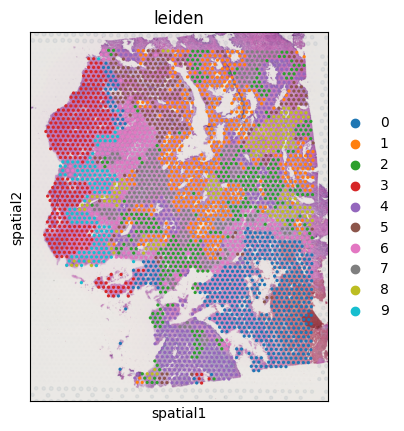

/opt/conda/envs/GraphST/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


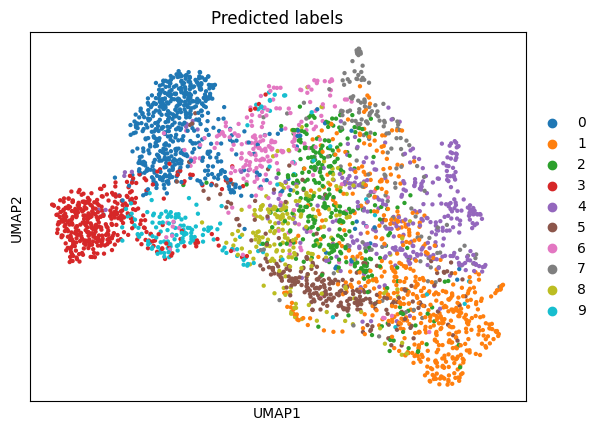

In [15]:
B2_visium = perform_graph_st(B2_visium, device, n_clusters, name_B2_10clsut)

### C3 :

In [16]:
C3_visium = sc.read_h5ad("/../../sbgenomics/project-files/st_pancreas_h5ad/PanCN_C3_visium.h5ad")

/opt/conda/envs/GraphST/lib/python3.8/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [17]:
name_C3_10clsut = "PanCN_C3_anndata_graphst_10_clusters"

Begin to train ST data...


100%|██████████| 600/600 [04:49<00:00,  2.07it/s]


Optimization finished for ST data!
Searching resolution...
resolution=1.989999999999999, cluster number=18
resolution=1.979999999999999, cluster number=17
resolution=1.969999999999999, cluster number=17
resolution=1.959999999999999, cluster number=17
resolution=1.949999999999999, cluster number=17
resolution=1.939999999999999, cluster number=16
resolution=1.9299999999999993, cluster number=17
resolution=1.9199999999999993, cluster number=17
resolution=1.9099999999999993, cluster number=17
resolution=1.8999999999999992, cluster number=16
resolution=1.8899999999999992, cluster number=16
resolution=1.8799999999999992, cluster number=16
resolution=1.8699999999999992, cluster number=17
resolution=1.8599999999999992, cluster number=15
resolution=1.8499999999999992, cluster number=16
resolution=1.8399999999999992, cluster number=16
resolution=1.8299999999999992, cluster number=17
resolution=1.8199999999999992, cluster number=17
resolution=1.8099999999999992, cluster number=15
resolution=1.799

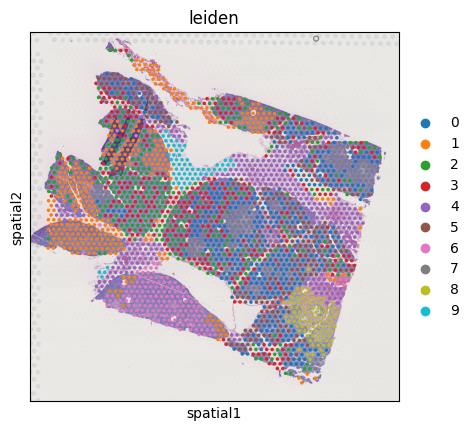

/opt/conda/envs/GraphST/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


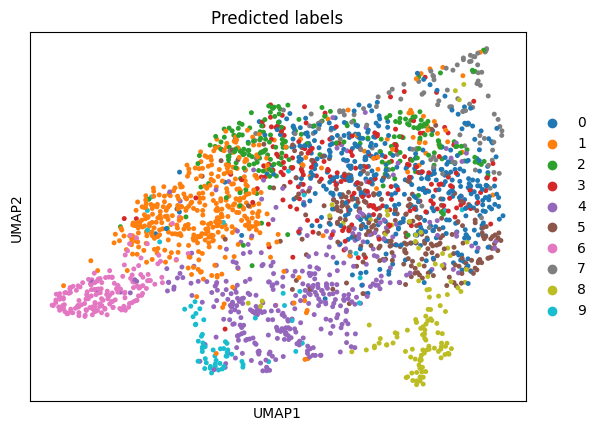

In [18]:
C3_visium = perform_graph_st(C3_visium, device, n_clusters, name_C3_10clsut)

### D4 :

In [19]:
D4_visium = sc.read_h5ad("/../../sbgenomics/project-files/st_pancreas_h5ad/PanCN_D4_visium.h5ad")

/opt/conda/envs/GraphST/lib/python3.8/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [20]:
name_D4_10clsut = "PanCN_D4_anndata_graphst_10_clusters"

Begin to train ST data...


100%|██████████| 600/600 [04:23<00:00,  2.28it/s]


Optimization finished for ST data!
Searching resolution...
resolution=1.989999999999999, cluster number=18
resolution=1.979999999999999, cluster number=16
resolution=1.969999999999999, cluster number=17
resolution=1.959999999999999, cluster number=17
resolution=1.949999999999999, cluster number=16
resolution=1.939999999999999, cluster number=16
resolution=1.9299999999999993, cluster number=16
resolution=1.9199999999999993, cluster number=16
resolution=1.9099999999999993, cluster number=16
resolution=1.8999999999999992, cluster number=16
resolution=1.8899999999999992, cluster number=15
resolution=1.8799999999999992, cluster number=15
resolution=1.8699999999999992, cluster number=15
resolution=1.8599999999999992, cluster number=16
resolution=1.8499999999999992, cluster number=15
resolution=1.8399999999999992, cluster number=15
resolution=1.8299999999999992, cluster number=15
resolution=1.8199999999999992, cluster number=16
resolution=1.8099999999999992, cluster number=16
resolution=1.799

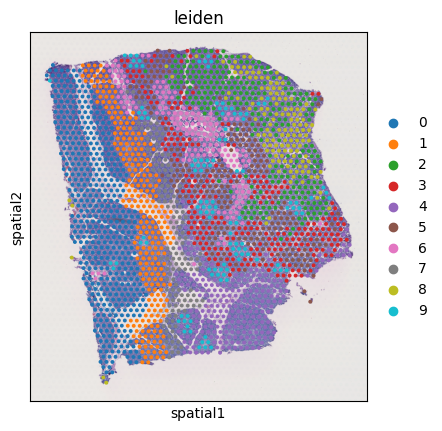

/opt/conda/envs/GraphST/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


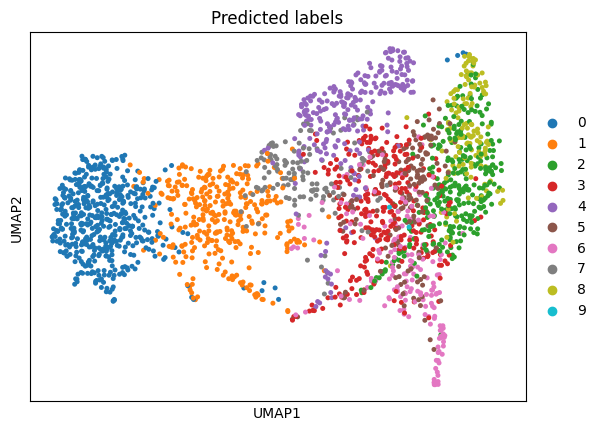

In [21]:
D4_visium = perform_graph_st(D4_visium, device, n_clusters, name_D4_10clsut)

## 2.2. With number of clusters = 6

In [22]:
n_clusters_6 = 6

### A1 :

In [23]:
A1_visium_6clust = sc.read_h5ad("/../../sbgenomics/project-files/st_pancreas_h5ad/PDAC_A1_visium.h5ad")

/opt/conda/envs/GraphST/lib/python3.8/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [24]:
name_A1_6clust = "PDAC_A1_anndata_graphst_6_clusters"

Begin to train ST data...


100%|██████████| 600/600 [04:52<00:00,  2.05it/s]


Optimization finished for ST data!
Searching resolution...
resolution=1.989999999999999, cluster number=21
resolution=1.979999999999999, cluster number=21
resolution=1.969999999999999, cluster number=21
resolution=1.959999999999999, cluster number=21
resolution=1.949999999999999, cluster number=21
resolution=1.939999999999999, cluster number=21
resolution=1.9299999999999993, cluster number=21
resolution=1.9199999999999993, cluster number=20
resolution=1.9099999999999993, cluster number=20
resolution=1.8999999999999992, cluster number=19
resolution=1.8899999999999992, cluster number=20
resolution=1.8799999999999992, cluster number=19
resolution=1.8699999999999992, cluster number=19
resolution=1.8599999999999992, cluster number=20
resolution=1.8499999999999992, cluster number=19
resolution=1.8399999999999992, cluster number=20
resolution=1.8299999999999992, cluster number=20
resolution=1.8199999999999992, cluster number=20
resolution=1.8099999999999992, cluster number=20
resolution=1.799

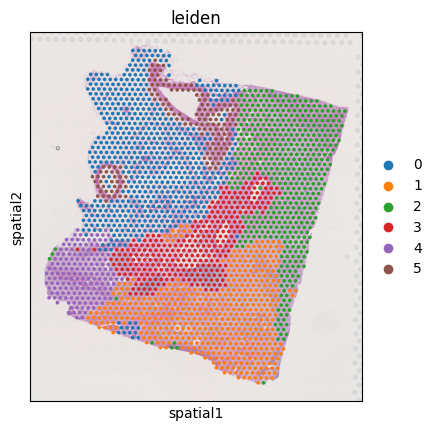

/opt/conda/envs/GraphST/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


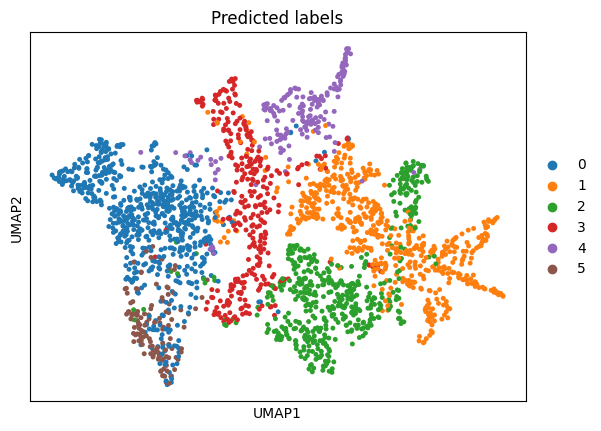

In [25]:
A1_visium_6clust = perform_graph_st(A1_visium_6clust, device, n_clusters_6, name_A1_6clust)

In [26]:
A1_visium_6clust

AnnData object with n_obs × n_vars = 2368 × 17943
    obs: 'in_tissue', 'array_row', 'array_col', 'leiden', 'domain'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg', 'log1p', 'neighbors', 'leiden', 'leiden_colors', 'umap', 'domain_colors'
    obsm: 'spatial', 'distance_matrix', 'graph_neigh', 'adj', 'label_CSL', 'feat', 'feat_a', 'emb', 'emb_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

### B2 :

In [27]:
B2_visium_6clust = sc.read_h5ad("/../../sbgenomics/project-files/st_pancreas_h5ad/PDAC_B2_visium.h5ad")

/opt/conda/envs/GraphST/lib/python3.8/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [28]:
name_B2_6clsut = "PDAC_B2_anndata_graphst_6_clusters"

Begin to train ST data...


100%|██████████| 600/600 [05:22<00:00,  1.86it/s]


Optimization finished for ST data!
Searching resolution...
resolution=1.989999999999999, cluster number=18
resolution=1.979999999999999, cluster number=17
resolution=1.969999999999999, cluster number=17
resolution=1.959999999999999, cluster number=16
resolution=1.949999999999999, cluster number=16
resolution=1.939999999999999, cluster number=17
resolution=1.9299999999999993, cluster number=18
resolution=1.9199999999999993, cluster number=16
resolution=1.9099999999999993, cluster number=17
resolution=1.8999999999999992, cluster number=17
resolution=1.8899999999999992, cluster number=17
resolution=1.8799999999999992, cluster number=17
resolution=1.8699999999999992, cluster number=17
resolution=1.8599999999999992, cluster number=17
resolution=1.8499999999999992, cluster number=18
resolution=1.8399999999999992, cluster number=17
resolution=1.8299999999999992, cluster number=16
resolution=1.8199999999999992, cluster number=16
resolution=1.8099999999999992, cluster number=16
resolution=1.799

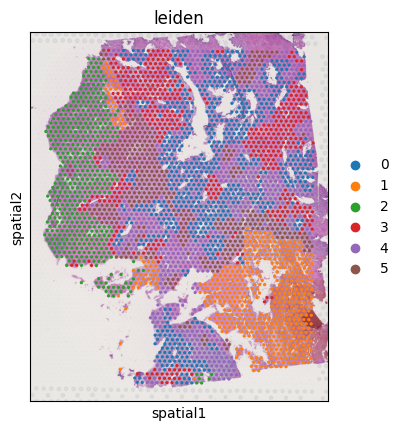

/opt/conda/envs/GraphST/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


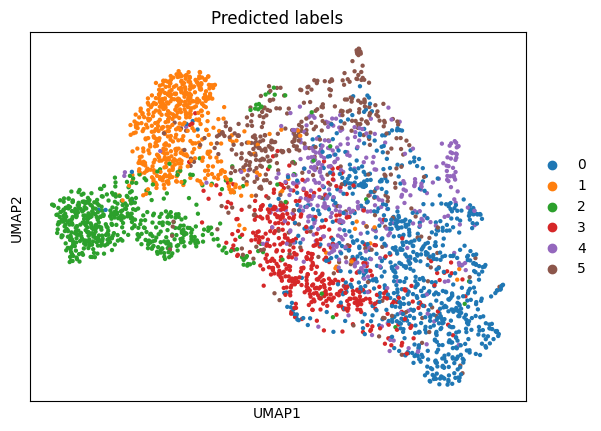

In [29]:
B2_visium_6clust = perform_graph_st(B2_visium_6clust, device, n_clusters_6, name_B2_6clsut)

### C3 :

In [30]:
C3_visium_6clust = sc.read_h5ad("/../../sbgenomics/project-files/st_pancreas_h5ad/PanCN_C3_visium.h5ad")

/opt/conda/envs/GraphST/lib/python3.8/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [31]:
name_C3_6clsut = "PanCN_C3_anndata_graphst_6_clusters"

Begin to train ST data...


100%|██████████| 600/600 [04:30<00:00,  2.22it/s]


Optimization finished for ST data!
Searching resolution...
resolution=1.989999999999999, cluster number=18
resolution=1.979999999999999, cluster number=17
resolution=1.969999999999999, cluster number=17
resolution=1.959999999999999, cluster number=17
resolution=1.949999999999999, cluster number=17
resolution=1.939999999999999, cluster number=16
resolution=1.9299999999999993, cluster number=17
resolution=1.9199999999999993, cluster number=17
resolution=1.9099999999999993, cluster number=17
resolution=1.8999999999999992, cluster number=16
resolution=1.8899999999999992, cluster number=16
resolution=1.8799999999999992, cluster number=16
resolution=1.8699999999999992, cluster number=17
resolution=1.8599999999999992, cluster number=15
resolution=1.8499999999999992, cluster number=16
resolution=1.8399999999999992, cluster number=16
resolution=1.8299999999999992, cluster number=17
resolution=1.8199999999999992, cluster number=17
resolution=1.8099999999999992, cluster number=15
resolution=1.799

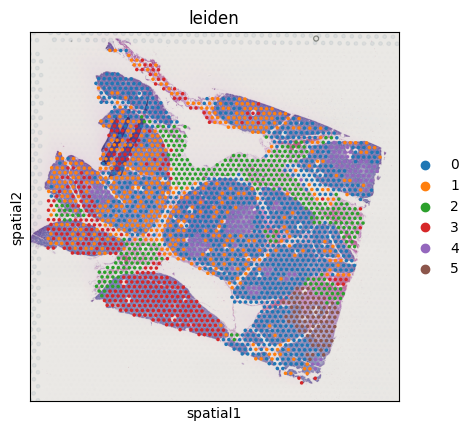

/opt/conda/envs/GraphST/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


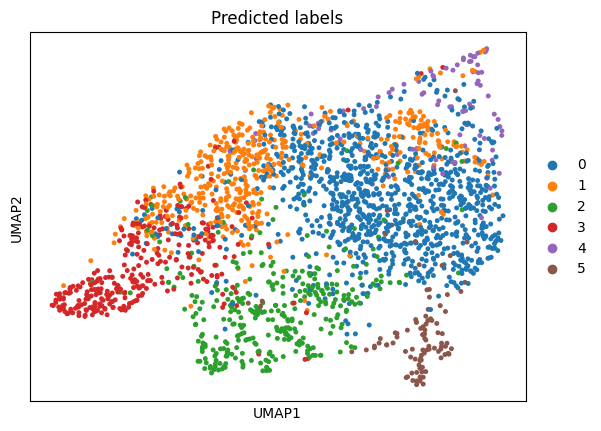

In [32]:
C3_visium_6clust = perform_graph_st(C3_visium_6clust, device, n_clusters_6, name_C3_6clsut)

### D4 :

In [33]:
D4_visium_6clust = sc.read_h5ad("/../../sbgenomics/project-files/st_pancreas_h5ad/PanCN_D4_visium.h5ad")

/opt/conda/envs/GraphST/lib/python3.8/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [34]:
name_D4_6clsut = "PanCN_D4_anndata_graphst_6_clusters"

Begin to train ST data...


100%|██████████| 600/600 [04:27<00:00,  2.25it/s]


Optimization finished for ST data!
Searching resolution...
resolution=1.989999999999999, cluster number=18
resolution=1.979999999999999, cluster number=16
resolution=1.969999999999999, cluster number=17
resolution=1.959999999999999, cluster number=17
resolution=1.949999999999999, cluster number=16
resolution=1.939999999999999, cluster number=16
resolution=1.9299999999999993, cluster number=16
resolution=1.9199999999999993, cluster number=16
resolution=1.9099999999999993, cluster number=16
resolution=1.8999999999999992, cluster number=16
resolution=1.8899999999999992, cluster number=15
resolution=1.8799999999999992, cluster number=15
resolution=1.8699999999999992, cluster number=15
resolution=1.8599999999999992, cluster number=16
resolution=1.8499999999999992, cluster number=15
resolution=1.8399999999999992, cluster number=15
resolution=1.8299999999999992, cluster number=15
resolution=1.8199999999999992, cluster number=16
resolution=1.8099999999999992, cluster number=16
resolution=1.799

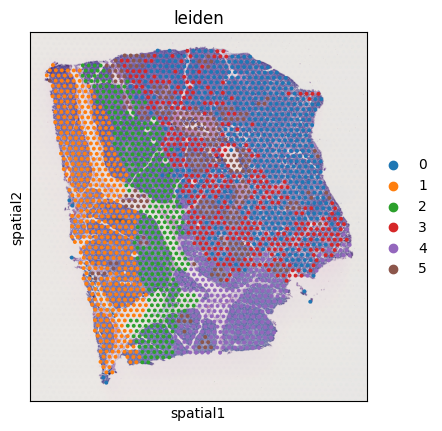

/opt/conda/envs/GraphST/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


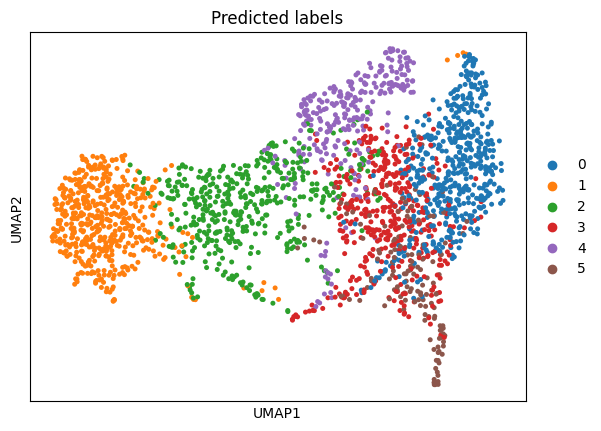

In [35]:
D4_visium_6clust = perform_graph_st(D4_visium_6clust, device, n_clusters_6, name_D4_6clsut)

# 2.3. On preprocessed data with number of clusters = 6

In [36]:
n_clusters_preprocessed = 6

### A1

In [37]:
A1_visium_preprocessed = sc.read_h5ad("/../../sbgenomics/project-files/visium_preprocessed/PDAC_A1_visium_preprocessed.h5ad")

In [38]:
name_A1_6clust = "PDAC_A1_anndata_graphst_6_clusters_preprocessed"

Begin to train ST data...


100%|██████████| 600/600 [04:04<00:00,  2.45it/s]


Optimization finished for ST data!
Searching resolution...
resolution=1.989999999999999, cluster number=19
resolution=1.979999999999999, cluster number=19
resolution=1.969999999999999, cluster number=18
resolution=1.959999999999999, cluster number=18
resolution=1.949999999999999, cluster number=18
resolution=1.939999999999999, cluster number=18
resolution=1.9299999999999993, cluster number=18
resolution=1.9199999999999993, cluster number=17
resolution=1.9099999999999993, cluster number=19
resolution=1.8999999999999992, cluster number=18
resolution=1.8899999999999992, cluster number=18
resolution=1.8799999999999992, cluster number=18
resolution=1.8699999999999992, cluster number=18
resolution=1.8599999999999992, cluster number=18
resolution=1.8499999999999992, cluster number=18
resolution=1.8399999999999992, cluster number=18
resolution=1.8299999999999992, cluster number=18
resolution=1.8199999999999992, cluster number=18
resolution=1.8099999999999992, cluster number=18
resolution=1.799

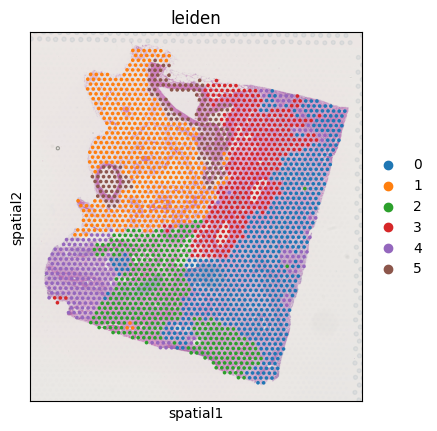

/opt/conda/envs/GraphST/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


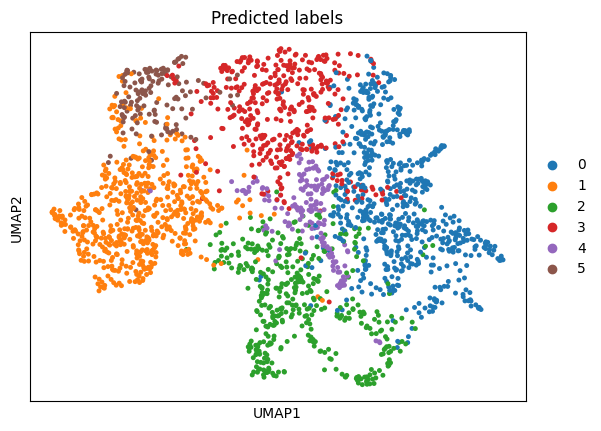

In [39]:
A1_visium_preprocessed  = perform_graph_st(A1_visium_preprocessed, device, n_clusters_preprocessed, name_A1_6clust)

### B2

In [40]:
B2_visium_preprocessed = sc.read_h5ad("/../../sbgenomics/project-files/visium_preprocessed/PDAC_B2_visium_preprocessed.h5ad")

In [41]:
name_B2_10clust = "PDAC_B2_anndata_graphst_6_clusters_preprocessed"

Begin to train ST data...


100%|██████████| 600/600 [04:13<00:00,  2.36it/s]


Optimization finished for ST data!
Searching resolution...
resolution=1.989999999999999, cluster number=20
resolution=1.979999999999999, cluster number=20
resolution=1.969999999999999, cluster number=20
resolution=1.959999999999999, cluster number=19
resolution=1.949999999999999, cluster number=19
resolution=1.939999999999999, cluster number=20
resolution=1.9299999999999993, cluster number=19
resolution=1.9199999999999993, cluster number=19
resolution=1.9099999999999993, cluster number=19
resolution=1.8999999999999992, cluster number=19
resolution=1.8899999999999992, cluster number=19
resolution=1.8799999999999992, cluster number=20
resolution=1.8699999999999992, cluster number=20
resolution=1.8599999999999992, cluster number=19
resolution=1.8499999999999992, cluster number=20
resolution=1.8399999999999992, cluster number=19
resolution=1.8299999999999992, cluster number=19
resolution=1.8199999999999992, cluster number=17
resolution=1.8099999999999992, cluster number=20
resolution=1.799

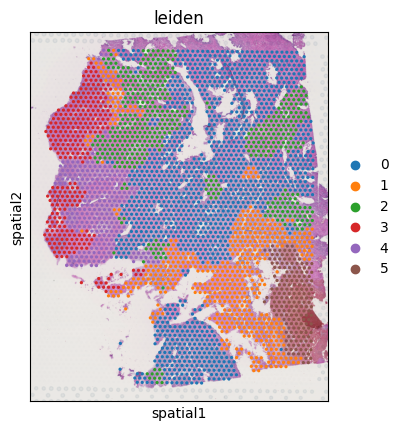

/opt/conda/envs/GraphST/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


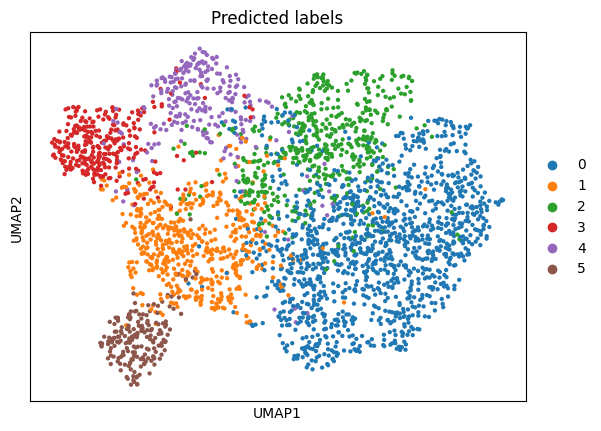

In [42]:
B2_visium_preprocessed = perform_graph_st(B2_visium_preprocessed, device, n_clusters_preprocessed, name_B2_10clust)

### C3

In [43]:
C3_visium_preprocessed = sc.read_h5ad("/../../sbgenomics/project-files/visium_preprocessed/PanCN_C3_visium_preprocessed.h5ad")

In [44]:
name_C3_10clust = "PanCN_C3_anndata_graphst_6_clusters_preprocessed"

Begin to train ST data...


100%|██████████| 600/600 [04:10<00:00,  2.40it/s]


Optimization finished for ST data!
Searching resolution...
resolution=1.989999999999999, cluster number=20
resolution=1.979999999999999, cluster number=20
resolution=1.969999999999999, cluster number=19
resolution=1.959999999999999, cluster number=21
resolution=1.949999999999999, cluster number=19
resolution=1.939999999999999, cluster number=20
resolution=1.9299999999999993, cluster number=20
resolution=1.9199999999999993, cluster number=20
resolution=1.9099999999999993, cluster number=20
resolution=1.8999999999999992, cluster number=20
resolution=1.8899999999999992, cluster number=20
resolution=1.8799999999999992, cluster number=19
resolution=1.8699999999999992, cluster number=19
resolution=1.8599999999999992, cluster number=20
resolution=1.8499999999999992, cluster number=18
resolution=1.8399999999999992, cluster number=19
resolution=1.8299999999999992, cluster number=19
resolution=1.8199999999999992, cluster number=19
resolution=1.8099999999999992, cluster number=19
resolution=1.799

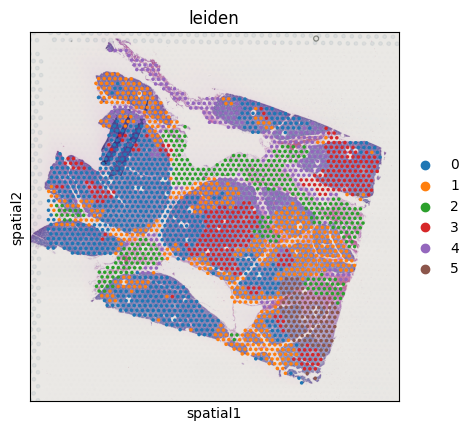

/opt/conda/envs/GraphST/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


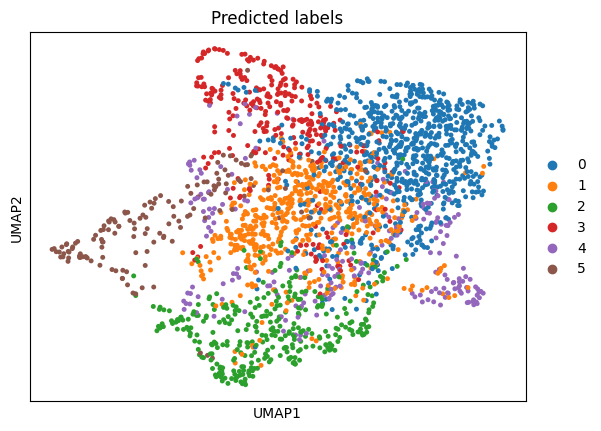

In [45]:
C3_visium_preprocessed = perform_graph_st(C3_visium_preprocessed, device, n_clusters_preprocessed, name_C3_10clust)

### D4

In [46]:
D4_visium_preprocessed = sc.read_h5ad("/../../sbgenomics/project-files/visium_preprocessed/PanCN_D4_visium_preprocessed.h5ad")

In [47]:
name_D4_10clust = "PanCN_D4_anndata_graphst_6_clusters_preprocessed"

Begin to train ST data...


100%|██████████| 600/600 [04:01<00:00,  2.48it/s]


Optimization finished for ST data!
Searching resolution...
resolution=1.989999999999999, cluster number=16
resolution=1.979999999999999, cluster number=16
resolution=1.969999999999999, cluster number=16
resolution=1.959999999999999, cluster number=17
resolution=1.949999999999999, cluster number=16
resolution=1.939999999999999, cluster number=16
resolution=1.9299999999999993, cluster number=16
resolution=1.9199999999999993, cluster number=16
resolution=1.9099999999999993, cluster number=16
resolution=1.8999999999999992, cluster number=17
resolution=1.8899999999999992, cluster number=16
resolution=1.8799999999999992, cluster number=17
resolution=1.8699999999999992, cluster number=16
resolution=1.8599999999999992, cluster number=17
resolution=1.8499999999999992, cluster number=17
resolution=1.8399999999999992, cluster number=16
resolution=1.8299999999999992, cluster number=16
resolution=1.8199999999999992, cluster number=16
resolution=1.8099999999999992, cluster number=16
resolution=1.799

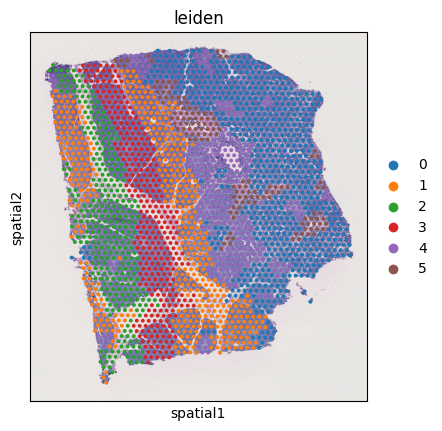

/opt/conda/envs/GraphST/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


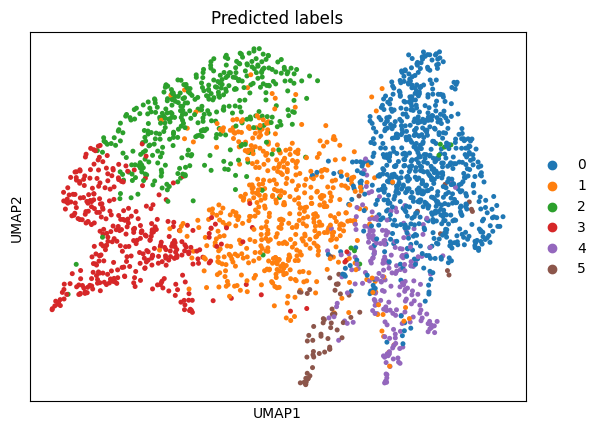

In [48]:
D4_visium_preprocessed = perform_graph_st(D4_visium_preprocessed, device, n_clusters_preprocessed, name_D4_10clust)